# Testing different Variations on the Variational Autoencoder

Biggest further improvement needs to be weighting each genre taste by the prevalance of genre so that way genres with more ratings on them don't hold higher weight

## Input rating matrix info 
Here is the collaborative filtering component where we use the matrix of ratings by the users

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])
raw_data = raw_data.loc[:, raw_data.columns != "timestamp"]
#make indices start at 0
raw_data["userId"] -= 1
raw_data["movieId"] -= 1
#make ratings center around 0
raw_data["rating"] -= 3

# create (943, 1682) matrix of user ratings per movie
user_ratings = pd.DataFrame(np.zeros((943,1682)))
for i in raw_data.index:
    user_ratings[raw_data["movieId"][i]][raw_data["userId"][i]] = raw_data["rating"][i]
user_ratings = user_ratings.to_numpy() 
user_ratings

C:\Users\leuch\AppData\Local\Temp\ipykernel_13636\2626815215.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("./data/Movielens100/u.data", sep = None, names=["userId", "movieId", "rating", "timestamp"])


array([[2., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.]])

In [2]:
user_ratings.shape

(943, 1682)

## Import the user information matrix I made 

In [3]:
user_info = pd.read_csv("./data/user_info.csv", index_col = 0)
user_info

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.824422,1.0,-0.528577,0.163282,-0.643886,-0.442094,-1.133953,0.682175,-0.240302,-0.297957,...,-0.528577,-0.499749,-0.384440,-0.586232,-0.470922,0.624520,0.682175,0.365074,-0.067338,-0.442094
1,1.554043,0.0,-0.557404,0.549569,-0.003917,-0.419032,-0.557404,1.241427,0.411197,-0.557404,...,-0.557404,-0.142289,-0.557404,-0.557404,-0.280661,1.933286,-0.142289,0.411197,-0.280661,-0.557404
2,-0.906438,1.0,-0.557404,-1.036383,-0.238085,-0.557404,-0.557404,-1.355702,-0.557404,-0.238085,...,-0.557404,-0.717064,-1.036383,-0.876723,-0.238085,-0.238085,-0.876723,-2.154000,-0.717064,-0.557404
3,-0.824422,1.0,-0.557404,1.621949,0.065268,-0.557404,-0.557404,1.933286,1.621949,0.065268,...,-0.557404,-0.557404,-0.246068,0.065268,0.999277,0.687941,0.999277,2.555958,0.376605,-0.557404
4,-0.086278,0.0,-0.506365,-0.149094,-0.149094,0.004022,-1.374024,-0.557404,-0.149094,-0.557404,...,-0.608443,-0.455327,-1.220908,-0.353249,-0.557404,-1.220908,0.310254,-0.608443,-0.404288,-0.608443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,-0.660390,0.0,-0.557404,2.193939,0.166634,-0.412597,-0.412597,2.773170,0.021826,-0.557404,...,-0.412597,-0.557404,-0.557404,-0.412597,-0.412597,2.049132,0.745864,1.325094,0.311441,-0.557404
939,-0.168294,1.0,-0.557404,0.284045,-0.557404,-0.304969,-0.052535,1.293784,0.199900,-0.557404,...,-0.557404,-0.304969,-0.557404,-0.473259,-0.220824,0.536480,-0.473259,0.031610,-0.220824,-0.557404
940,-1.152486,1.0,-0.557404,1.933286,1.310613,0.999277,0.376605,1.933286,-0.557404,-0.557404,...,-0.557404,-0.557404,-0.557404,-0.246068,0.065268,0.065268,1.621949,1.621949,0.065268,-0.557404
941,1.143963,0.0,-0.557404,1.301320,1.208383,0.093149,1.022511,1.673064,-0.557404,-0.557404,...,-0.371532,-0.371532,-0.371532,0.093149,0.279022,1.673064,0.093149,1.301320,1.022511,-0.092723


## Create Training and Testing data

In [4]:

#this is the final labels as is
labels = user_ratings

#The features will be 80% of the users ratings concatenated with the user_info

# create a mask of 0 and 1 values where half are 0 and 0.8 (Default) are 1. 
#The ratio of masked values is something that can and should be optimized. 
mask_magnitude = 1.3
random_mask = np.clip((np.random.randn(1682) + mask_magnitude).round(), a_max = 1, a_min = 0)

user_ratings *= random_mask
features = np.concatenate((user_info, user_ratings), axis=1)

## Make sure to shuffle data

## Begin model and tuning of Hyperparameters

In [5]:
from torch.utils.data import Dataset, DataLoader
from torch import nn 
import torch
from sklearn.metrics import precision_recall_fscore_support
device = "cuda"

class MovielensDataset(Dataset):
    def __init__(self, X, y):
        # input_noise The variance of the noise 
        
        
        self.X = X
        self.y = y
        
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


#noise layers for regularization
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            return x + torch.autograd.Variable(torch.randn(x.size()).cuda() * self.stddev)
        return x
    

# This is a standard VAE but using MSE as the reconstruction term. 

#Actually just rename this out and make loss function a parameter
class VAE(nn.Module):
    def __init__(self, recon_loss_fcn = "MSE", residual_user_info = False, dropout_rate = 0.0, nonLinearity = "LeakyRelu", fixed_variance = False, deterministicEval = False, noiseLayerStd = 0.2, hidden_size =1024, latent_size = 512):
        #fixed variance is false if regular or equal to the value of the parameter
        super().__init__()
        
        if nonLinearity == "LeakyRelu":
            nonLin = nn.LeakyReLU
        elif nonLinearity == "Relu":
            nonLin = nn.ReLU
        elif nonLinearity == "Tanh":
            nonLin = nn.Tanh
        elif nonLinearity == "Sigmoid":
            nonLin = nn.Sigmoid
        
        self.encoder = nn.Sequential(
            #Encoder
            nn.Linear(1703, hidden_size),
            nonLin(),
            GaussianNoise(noiseLayerStd),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size,hidden_size),
            nonLin(),
            GaussianNoise(noiseLayerStd),
            nn.Dropout(dropout_rate),
        )
        self.decoder = nn.Sequential(
            #Decoder
            nn.Linear(latent_size,hidden_size),
            nonLin(),
            GaussianNoise(noiseLayerStd),
            nn.Dropout(dropout_rate),
        )
        # distribution parameters
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_var = nn.Linear(hidden_size, latent_size)
        final_layer_size = hidden_size
        self.residual_user_info = residual_user_info
        if self.residual_user_info == True:
            final_layer_size += 22
        self.final_layer = nn.Linear(final_layer_size,1682)
        self.final_activation = nn.Tanh()
        
        
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        #for evaluation purposes
        self.test_mse = 1000
        self.mse_loss_fcn = nn.MSELoss()
        self.recon_loss_fcn = recon_loss_fcn
        
        # for varieties of VAE
        self.fixed_variance = fixed_variance
        self.deterministicEval = deterministicEval
        
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing data under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=1)
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def forward(self, x):
        
        
        
        
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded) if self.fixed_variance == False else self.fc_var(x_encoded) / self.fc_var(x_encoded) * self.fixed_variance
        
        # sample z from q
        std = torch.exp(log_var / 2)
        if self.training == False and self.deterministicEval == True:
            std = std * 0
    
        #perform the kernel trick to allow for backprop through sampling
        epsilon = torch.distributions.Normal(0, 1).rsample()
        z = mu + epsilon * std
        # decoded
        if self.residual_user_info == True:
            final_layer_input = torch.concat((self.decoder(z), x[:, :22]), axis = 1)
        else:
            final_layer_input = self.decoder(z)
        ratings = self.final_layer(final_layer_input) 
        ratings = self.final_activation(ratings) * 2
        return ratings, z, mu, std
    
    def vae_loss(self, x_hat, x, z, mu, std):
        # reconstruction loss
        if self.recon_loss_fcn == "MSE":
            recon_loss = self.mse_loss_fcn(x_hat, x) * 10000
        else: 
            recon_loss = -self.gaussian_likelihood(x_hat, self.log_scale, x)
        
        # kl
        if self.training == True and self.fixed_variance == False:
            kl = self.kl_divergence(z, mu, std)
        else:
            kl = 0
        
        # elbo
        elbo = (kl + recon_loss).mean()

        return elbo

def train(dataloader, model,  optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        #compute prediction error
        pred, z, mu, std = model(X)
        loss = model.vae_loss(pred, y, z, mu, std)
        mse_loss = mse_loss_fcn(pred, y)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0 and batch % 64 == 0:
            loss , current = loss.item(), (batch+1) * len(X)
            #print("Epoch : " + str(epoch))
            #print(f"loss: {loss:>7f}")
            #print(f"MSE loss: {mse_loss:>7f}")
            losses.append(loss)
            mse_losses.append(mse_loss.item())

def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    num_batches= len(dataloader)
    model.eval()
    test_loss, correct, test_mse_loss = 0,0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            
            
            pred, z, mu, std = model(X)
            test_loss += model.vae_loss(pred, y, z, mu, std).item()
            test_mse_loss += mse_loss_fcn(pred, y)
    test_loss /= num_batches
    test_mse_loss /= num_batches
    if epoch % 100 ==0:
        test_losses.append(test_loss)
        #Calculate RMSE on just the rated ones like the papers do 
        nonzero_indices = y.nonzero().split( 1, dim=1)
        relevant_rmse = torch.sqrt(mse_loss_fcn(y[nonzero_indices], pred[nonzero_indices]))#torch.sqrt((y[nonzero_indices] - pred[nonzero_indices] ** 2).mean())
        
        #print(f"Test Error: \n Avg Loss : {test_loss:>8f} ")
        #print(f" Test MSE loss: {test_mse_loss:>7f}")
        #print("Relevant RMSE loss: " + str(relevant_rmse.item()))
        test_mse_losses.append(test_mse_loss.item())
        model.test_mse = relevant_rmse.item()
    
        
        

## The actual search 
The following contains all of the logic you need to do to restart everything over so long as you've already loaded the ones above

In [8]:
from sklearn.utils import shuffle

epochs = 2500


results = pd.read_csv("./data/model_results.csv", header= 0, index_col = 0)

all_time_lowest_mse = 0.5516
iteration = 11
while(True):
    #New set of hyperparams
    X, y = shuffle(features, labels, random_state=1)

    lowest_test_mse_score = 1000
    losses = []
    mse_losses = []    
    test_losses = []
    test_mse_losses = []


    #Search params
    learning_rate = np.random.choice([5e-5, 1e-4])
    deterministicEval = np.random.choice([True, False])
    batch_size = int(np.random.choice([32, 64, 128]))
    hidden_size = int(np.random.choice([1024, 2048, 4096]))
    latent_size = int(np.random.choice([512, 1024, 2048]))
    fixed_variance = np.random.choice([False, 0.1, 0.3, 0.5])
    dropout_rate = float(np.random.choice([0.0, 0.1, 0.3, 0.5]))
    l2_weight = float(np.random.choice([0.0, 1e-5, 1e-4, 1e-3]))
    noiseLayerStd = float(np.random.choice([0.0, 0.1, 0.3, 0.5]))
    optimizer_fcn = np.random.choice(["Adam", "Adagrad", "RMSProp"])
    nonLinearity = np.random.choice(["LeakyRelu", "Relu", "Tanh", "Sigmoid"])
    residual_user_info = np.random.choice([True, False])
    recon_loss_fcn = np.random.choice(["MSE", "Likelihood"])

    train_dataset = MovielensDataset(X[:843], y[:843])
    test_dataset = MovielensDataset(X[843:],y[843:])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)


    
    model = VAE(recon_loss_fcn = recon_loss_fcn, residual_user_info = residual_user_info, nonLinearity = nonLinearity, dropout_rate = dropout_rate, fixed_variance = False, deterministicEval = deterministicEval, noiseLayerStd = noiseLayerStd, hidden_size = hidden_size, latent_size = latent_size ).to(device)

    if optimizer_fcn == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr =  learning_rate, weight_decay = l2_weight)
    elif optimizer_fcn == "Adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr =  learning_rate)
        l2_weight = 0
    elif optimizer_fcn == "RMSProp":
        learning_rate = np.random.choice([5e-6, 1e-5])
        optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
        l2_weight = 0

    mse_loss_fcn = nn.MSELoss()

    hyperparameters = [recon_loss_fcn, learning_rate, deterministicEval,  batch_size, hidden_size, latent_size, fixed_variance, dropout_rate, l2_weight, noiseLayerStd, optimizer_fcn, nonLinearity, residual_user_info]
    print("iteration : " + str(iteration) + " using hyperparameters : " + str(hyperparameters))

    for t in range(epochs):
        train(train_dataloader, model,  optimizer, t)
        test(test_dataloader, model, t )
        if t % 100 == 0:
            if model.test_mse < lowest_test_mse_score:
                lowest_test_mse_score = model.test_mse
                
                
                if model.test_mse < all_time_lowest_mse:
                    torch.save(model.state_dict(), "./models/best_late.pth")
                    print("NEW RECORD : " + str(model.test_mse))
                    print("New best using hyper parameters : " + str(hyperparameters)  )
                    all_time_lowest_mse = model.test_mse
    hyperparameters.append(lowest_test_mse_score)
    results = pd.concat((results, pd.DataFrame([ hyperparameters], columns= results.columns)))
    results.to_csv("./data/model_results.csv", index=True)
    iteration+= 1

iteration : 11 using hyperparameters : ['MSE', 1e-05, False, 32, 1024, 1024, 0.0, 0.0, 0, 0.0, 'RMSProp', 'Relu', False]
iteration : 12 using hyperparameters : ['MSE', 0.0001, False, 32, 1024, 1024, 0.0, 0.5, 0, 0.5, 'Adagrad', 'Sigmoid', False]
iteration : 13 using hyperparameters : ['MSE', 5e-05, False, 128, 1024, 2048, 0.1, 0.5, 0, 0.5, 'Adagrad', 'Tanh', False]
iteration : 14 using hyperparameters : ['MSE', 0.0001, True, 64, 4096, 1024, 0.3, 0.1, 0, 0.1, 'Adagrad', 'LeakyRelu', True]
iteration : 15 using hyperparameters : ['MSE', 5e-05, True, 128, 1024, 2048, 0.1, 0.1, 0.001, 0.1, 'Adam', 'LeakyRelu', False]
iteration : 16 using hyperparameters : ['MSE', 0.0001, True, 32, 4096, 1024, 0.5, 0.1, 0.0001, 0.5, 'Adam', 'Sigmoid', False]
iteration : 17 using hyperparameters : ['Likelihood', 0.0001, True, 64, 4096, 512, 0.1, 0.3, 0.0001, 0.5, 'Adam', 'Sigmoid', True]
iteration : 18 using hyperparameters : ['MSE', 1e-05, False, 32, 1024, 2048, 0.3, 0.3, 0, 0.1, 'RMSProp', 'Tanh', False]
it

iteration : 77 using hyperparameters : ['MSE', 5e-05, False, 64, 1024, 2048, 0.0, 0.3, 1e-05, 0.1, 'Adam', 'Tanh', False]
iteration : 78 using hyperparameters : ['Likelihood', 1e-05, False, 32, 1024, 1024, 0.0, 0.3, 0, 0.5, 'RMSProp', 'Tanh', True]
iteration : 79 using hyperparameters : ['Likelihood', 5e-05, True, 64, 4096, 512, 0.5, 0.3, 0, 0.5, 'Adagrad', 'LeakyRelu', False]
iteration : 80 using hyperparameters : ['MSE', 5e-06, False, 64, 2048, 2048, 0.3, 0.0, 0, 0.1, 'RMSProp', 'Tanh', False]
iteration : 81 using hyperparameters : ['Likelihood', 0.0001, False, 128, 2048, 512, 0.5, 0.3, 0.001, 0.5, 'Adam', 'LeakyRelu', True]
iteration : 82 using hyperparameters : ['MSE', 5e-05, False, 64, 4096, 512, 0.0, 0.3, 0.001, 0.0, 'Adam', 'LeakyRelu', False]
iteration : 83 using hyperparameters : ['Likelihood', 5e-05, True, 32, 1024, 1024, 0.5, 0.5, 0, 0.1, 'Adagrad', 'Relu', True]
iteration : 84 using hyperparameters : ['MSE', 1e-05, False, 32, 2048, 1024, 0.0, 0.5, 0, 0.1, 'RMSProp', 'Sigmoi

iteration : 142 using hyperparameters : ['MSE', 1e-05, False, 64, 4096, 512, 0.3, 0.1, 0, 0.1, 'RMSProp', 'Relu', True]
iteration : 143 using hyperparameters : ['Likelihood', 5e-06, True, 128, 1024, 2048, 0.0, 0.5, 0, 0.5, 'RMSProp', 'LeakyRelu', True]
iteration : 144 using hyperparameters : ['Likelihood', 1e-05, False, 64, 2048, 1024, 0.3, 0.5, 0, 0.1, 'RMSProp', 'Sigmoid', True]
iteration : 145 using hyperparameters : ['MSE', 0.0001, False, 32, 1024, 512, 0.5, 0.0, 0.001, 0.1, 'Adam', 'LeakyRelu', False]
iteration : 146 using hyperparameters : ['MSE', 5e-05, False, 128, 1024, 1024, 0.1, 0.3, 0, 0.0, 'Adagrad', 'Relu', False]
iteration : 147 using hyperparameters : ['MSE', 1e-05, False, 128, 2048, 512, 0.5, 0.3, 0, 0.0, 'RMSProp', 'LeakyRelu', True]
iteration : 148 using hyperparameters : ['Likelihood', 5e-05, False, 32, 1024, 1024, 0.5, 0.1, 1e-05, 0.0, 'Adam', 'LeakyRelu', True]
iteration : 149 using hyperparameters : ['MSE', 0.0001, False, 64, 1024, 2048, 0.0, 0.1, 0, 0.1, 'Adagrad

iteration : 199 using hyperparameters : ['Likelihood', 5e-05, False, 32, 4096, 2048, 0.0, 0.5, 0.0, 0.1, 'Adam', 'Tanh', True]
iteration : 200 using hyperparameters : ['Likelihood', 0.0001, True, 128, 4096, 1024, 0.5, 0.5, 0.0001, 0.5, 'Adam', 'Sigmoid', False]
iteration : 201 using hyperparameters : ['MSE', 0.0001, False, 64, 1024, 1024, 0.1, 0.3, 0, 0.3, 'Adagrad', 'LeakyRelu', True]
iteration : 202 using hyperparameters : ['MSE', 5e-05, True, 128, 4096, 1024, 0.1, 0.5, 0, 0.5, 'Adagrad', 'Sigmoid', False]
iteration : 203 using hyperparameters : ['MSE', 0.0001, True, 128, 2048, 2048, 0.0, 0.3, 0.0001, 0.1, 'Adam', 'LeakyRelu', False]
iteration : 204 using hyperparameters : ['Likelihood', 1e-05, False, 64, 2048, 2048, 0.5, 0.5, 0, 0.3, 'RMSProp', 'Tanh', True]
iteration : 205 using hyperparameters : ['MSE', 5e-05, True, 64, 2048, 1024, 0.0, 0.0, 1e-05, 0.3, 'Adam', 'Relu', False]
iteration : 206 using hyperparameters : ['MSE', 5e-06, True, 128, 4096, 2048, 0.3, 0.0, 0, 0.0, 'RMSProp',

iteration : 261 using hyperparameters : ['MSE', 5e-05, True, 64, 2048, 2048, 0.5, 0.0, 0, 0.5, 'Adagrad', 'Relu', False]
iteration : 262 using hyperparameters : ['MSE', 5e-06, False, 32, 1024, 512, 0.0, 0.3, 0, 0.1, 'RMSProp', 'Relu', False]
iteration : 263 using hyperparameters : ['Likelihood', 1e-05, False, 32, 1024, 1024, 0.5, 0.0, 0, 0.0, 'RMSProp', 'Relu', False]
iteration : 264 using hyperparameters : ['Likelihood', 5e-05, False, 64, 2048, 1024, 0.3, 0.3, 0.001, 0.3, 'Adam', 'Tanh', False]
iteration : 265 using hyperparameters : ['Likelihood', 5e-05, False, 128, 1024, 2048, 0.1, 0.0, 1e-05, 0.0, 'Adam', 'LeakyRelu', True]
iteration : 266 using hyperparameters : ['MSE', 0.0001, False, 64, 4096, 512, 0.1, 0.3, 0.001, 0.1, 'Adam', 'Tanh', True]
iteration : 267 using hyperparameters : ['Likelihood', 0.0001, True, 32, 4096, 512, 0.5, 0.5, 0, 0.5, 'Adagrad', 'Relu', True]
iteration : 268 using hyperparameters : ['Likelihood', 5e-05, False, 32, 4096, 2048, 0.5, 0.1, 0.001, 0.5, 'Adam', 

iteration : 326 using hyperparameters : ['Likelihood', 1e-05, True, 32, 2048, 512, 0.3, 0.1, 0, 0.5, 'RMSProp', 'LeakyRelu', True]
iteration : 327 using hyperparameters : ['MSE', 5e-05, True, 128, 1024, 1024, 0.3, 0.5, 0, 0.0, 'Adagrad', 'Relu', True]
iteration : 328 using hyperparameters : ['MSE', 5e-06, True, 64, 2048, 512, 0.1, 0.0, 0, 0.5, 'RMSProp', 'LeakyRelu', False]
iteration : 329 using hyperparameters : ['MSE', 0.0001, False, 128, 4096, 2048, 0.3, 0.3, 0.0, 0.3, 'Adam', 'Sigmoid', False]
iteration : 330 using hyperparameters : ['MSE', 0.0001, True, 128, 4096, 512, 0.0, 0.5, 0, 0.5, 'Adagrad', 'Sigmoid', False]
iteration : 331 using hyperparameters : ['Likelihood', 1e-05, False, 32, 4096, 512, 0.5, 0.5, 0, 0.5, 'RMSProp', 'Sigmoid', True]
iteration : 332 using hyperparameters : ['Likelihood', 5e-06, False, 32, 4096, 1024, 0.0, 0.1, 0, 0.5, 'RMSProp', 'Tanh', True]
iteration : 333 using hyperparameters : ['MSE', 5e-05, False, 128, 4096, 1024, 0.5, 0.1, 0, 0.0, 'Adagrad', 'Leaky

iteration : 391 using hyperparameters : ['MSE', 5e-05, True, 128, 4096, 1024, 0.0, 0.3, 0.0, 0.1, 'Adam', 'Sigmoid', False]
iteration : 392 using hyperparameters : ['MSE', 1e-05, True, 32, 1024, 1024, 0.3, 0.1, 0, 0.1, 'RMSProp', 'Tanh', True]
iteration : 393 using hyperparameters : ['MSE', 0.0001, True, 128, 1024, 1024, 0.1, 0.0, 0.0001, 0.0, 'Adam', 'Sigmoid', False]
iteration : 394 using hyperparameters : ['MSE', 5e-06, True, 128, 2048, 2048, 0.5, 0.3, 0, 0.0, 'RMSProp', 'Sigmoid', True]
iteration : 395 using hyperparameters : ['Likelihood', 5e-05, False, 32, 4096, 512, 0.1, 0.3, 0, 0.3, 'Adagrad', 'LeakyRelu', True]
iteration : 396 using hyperparameters : ['Likelihood', 5e-05, False, 32, 2048, 2048, 0.0, 0.5, 0.0, 0.0, 'Adam', 'Tanh', False]
iteration : 397 using hyperparameters : ['Likelihood', 0.0001, False, 64, 2048, 512, 0.1, 0.1, 0.0001, 0.3, 'Adam', 'Relu', False]
iteration : 398 using hyperparameters : ['Likelihood', 0.0001, True, 32, 2048, 512, 0.0, 0.1, 0, 0.5, 'Adagrad', 

iteration : 456 using hyperparameters : ['MSE', 1e-05, True, 64, 2048, 512, 0.0, 0.3, 0, 0.5, 'RMSProp', 'Relu', False]
iteration : 457 using hyperparameters : ['MSE', 5e-05, True, 128, 2048, 2048, 0.1, 0.5, 0.0, 0.3, 'Adam', 'Tanh', True]
iteration : 458 using hyperparameters : ['MSE', 5e-05, True, 64, 4096, 1024, 0.5, 0.0, 0, 0.5, 'Adagrad', 'LeakyRelu', False]
iteration : 459 using hyperparameters : ['MSE', 5e-06, True, 128, 2048, 512, 0.3, 0.1, 0, 0.0, 'RMSProp', 'Tanh', True]
iteration : 460 using hyperparameters : ['MSE', 5e-06, False, 64, 2048, 1024, 0.1, 0.5, 0, 0.5, 'RMSProp', 'Tanh', False]
iteration : 461 using hyperparameters : ['Likelihood', 1e-05, True, 64, 2048, 1024, 0.1, 0.0, 0, 0.3, 'RMSProp', 'LeakyRelu', False]
iteration : 462 using hyperparameters : ['MSE', 5e-06, True, 32, 1024, 2048, 0.1, 0.5, 0, 0.3, 'RMSProp', 'Sigmoid', True]
iteration : 463 using hyperparameters : ['MSE', 5e-05, False, 128, 2048, 2048, 0.1, 0.1, 0, 0.1, 'Adagrad', 'LeakyRelu', True]
iteration

iteration : 521 using hyperparameters : ['MSE', 0.0001, False, 32, 1024, 2048, 0.0, 0.1, 0, 0.0, 'Adagrad', 'Sigmoid', False]
iteration : 522 using hyperparameters : ['MSE', 5e-06, True, 128, 4096, 1024, 0.5, 0.0, 0, 0.3, 'RMSProp', 'Sigmoid', True]
iteration : 523 using hyperparameters : ['Likelihood', 5e-05, False, 128, 1024, 1024, 0.5, 0.3, 0.0, 0.5, 'Adam', 'Relu', False]
iteration : 524 using hyperparameters : ['Likelihood', 0.0001, False, 32, 1024, 1024, 0.3, 0.1, 0, 0.0, 'Adagrad', 'Sigmoid', True]
iteration : 525 using hyperparameters : ['MSE', 5e-05, True, 64, 4096, 2048, 0.0, 0.1, 0.001, 0.0, 'Adam', 'Sigmoid', False]
iteration : 526 using hyperparameters : ['Likelihood', 5e-05, True, 32, 4096, 1024, 0.5, 0.5, 0, 0.1, 'Adagrad', 'Relu', True]
iteration : 527 using hyperparameters : ['MSE', 5e-05, True, 32, 2048, 2048, 0.0, 0.3, 1e-05, 0.5, 'Adam', 'Sigmoid', True]
iteration : 528 using hyperparameters : ['Likelihood', 5e-06, False, 64, 2048, 1024, 0.0, 0.0, 0, 0.0, 'RMSProp',

iteration : 586 using hyperparameters : ['MSE', 5e-06, True, 64, 1024, 512, 0.5, 0.1, 0, 0.0, 'RMSProp', 'Relu', False]
iteration : 587 using hyperparameters : ['MSE', 5e-05, True, 32, 4096, 1024, 0.0, 0.1, 0.001, 0.3, 'Adam', 'Relu', True]
iteration : 588 using hyperparameters : ['MSE', 0.0001, True, 64, 2048, 512, 0.3, 0.5, 1e-05, 0.3, 'Adam', 'Sigmoid', True]
iteration : 589 using hyperparameters : ['Likelihood', 1e-05, True, 64, 4096, 512, 0.3, 0.0, 0, 0.0, 'RMSProp', 'LeakyRelu', True]
iteration : 590 using hyperparameters : ['Likelihood', 1e-05, False, 32, 4096, 2048, 0.1, 0.3, 0, 0.5, 'RMSProp', 'LeakyRelu', True]
iteration : 591 using hyperparameters : ['Likelihood', 5e-05, True, 64, 2048, 512, 0.1, 0.5, 1e-05, 0.1, 'Adam', 'Relu', False]
iteration : 592 using hyperparameters : ['Likelihood', 0.0001, True, 128, 2048, 512, 0.0, 0.0, 0, 0.3, 'Adagrad', 'Tanh', True]
iteration : 593 using hyperparameters : ['MSE', 5e-05, True, 64, 1024, 1024, 0.5, 0.1, 0.0, 0.0, 'Adam', 'LeakyRelu

iteration : 651 using hyperparameters : ['Likelihood', 5e-05, False, 128, 1024, 512, 0.5, 0.1, 0, 0.5, 'Adagrad', 'LeakyRelu', True]
iteration : 652 using hyperparameters : ['Likelihood', 1e-05, True, 32, 2048, 2048, 0.1, 0.1, 0, 0.1, 'RMSProp', 'LeakyRelu', False]
iteration : 653 using hyperparameters : ['MSE', 5e-05, False, 128, 4096, 512, 0.3, 0.5, 0, 0.1, 'Adagrad', 'Relu', False]
iteration : 654 using hyperparameters : ['Likelihood', 1e-05, False, 128, 1024, 512, 0.5, 0.1, 0, 0.3, 'RMSProp', 'Tanh', True]
iteration : 655 using hyperparameters : ['Likelihood', 5e-05, False, 64, 1024, 512, 0.5, 0.0, 0, 0.0, 'Adagrad', 'LeakyRelu', False]
iteration : 656 using hyperparameters : ['Likelihood', 5e-06, True, 128, 1024, 1024, 0.5, 0.1, 0, 0.1, 'RMSProp', 'LeakyRelu', False]
iteration : 657 using hyperparameters : ['Likelihood', 0.0001, False, 128, 1024, 1024, 0.1, 0.3, 0, 0.3, 'Adagrad', 'Sigmoid', True]
iteration : 658 using hyperparameters : ['Likelihood', 0.0001, False, 32, 4096, 512,

iteration : 715 using hyperparameters : ['MSE', 0.0001, True, 128, 2048, 1024, 0.1, 0.0, 0, 0.1, 'Adagrad', 'LeakyRelu', False]
iteration : 716 using hyperparameters : ['Likelihood', 1e-05, True, 128, 1024, 2048, 0.3, 0.5, 0, 0.5, 'RMSProp', 'LeakyRelu', False]
iteration : 717 using hyperparameters : ['MSE', 1e-05, True, 32, 2048, 512, 0.0, 0.1, 0, 0.3, 'RMSProp', 'Relu', True]
iteration : 718 using hyperparameters : ['Likelihood', 0.0001, False, 32, 4096, 1024, 0.1, 0.0, 0, 0.5, 'Adagrad', 'Tanh', True]
iteration : 719 using hyperparameters : ['Likelihood', 0.0001, True, 32, 2048, 2048, 0.0, 0.5, 0, 0.1, 'Adagrad', 'Relu', False]
iteration : 720 using hyperparameters : ['MSE', 5e-05, True, 128, 4096, 2048, 0.3, 0.1, 0.001, 0.1, 'Adam', 'Tanh', True]
iteration : 721 using hyperparameters : ['MSE', 0.0001, False, 128, 1024, 2048, 0.3, 0.0, 0, 0.0, 'Adagrad', 'Sigmoid', False]
iteration : 722 using hyperparameters : ['MSE', 0.0001, False, 64, 2048, 2048, 0.1, 0.0, 0, 0.3, 'Adagrad', 'Lea

iteration : 780 using hyperparameters : ['Likelihood', 5e-05, False, 128, 4096, 512, 0.5, 0.0, 0, 0.3, 'Adagrad', 'Sigmoid', True]
iteration : 781 using hyperparameters : ['Likelihood', 5e-05, False, 128, 4096, 512, 0.3, 0.3, 0.0001, 0.5, 'Adam', 'LeakyRelu', True]
iteration : 782 using hyperparameters : ['Likelihood', 5e-06, False, 128, 4096, 1024, 0.3, 0.3, 0, 0.0, 'RMSProp', 'Sigmoid', False]
iteration : 783 using hyperparameters : ['MSE', 5e-05, False, 32, 1024, 2048, 0.5, 0.1, 0, 0.0, 'Adagrad', 'Relu', True]
iteration : 784 using hyperparameters : ['Likelihood', 5e-05, False, 128, 4096, 1024, 0.1, 0.3, 0.0, 0.0, 'Adam', 'Sigmoid', True]
iteration : 785 using hyperparameters : ['Likelihood', 1e-05, True, 64, 1024, 2048, 0.5, 0.0, 0, 0.3, 'RMSProp', 'Tanh', False]
iteration : 786 using hyperparameters : ['MSE', 5e-06, False, 64, 4096, 512, 0.3, 0.1, 0, 0.0, 'RMSProp', 'Relu', True]
iteration : 787 using hyperparameters : ['MSE', 5e-05, False, 128, 2048, 2048, 0.0, 0.1, 0, 0.5, 'Ada

iteration : 845 using hyperparameters : ['Likelihood', 1e-05, True, 64, 2048, 2048, 0.0, 0.0, 0, 0.3, 'RMSProp', 'Sigmoid', True]
iteration : 846 using hyperparameters : ['Likelihood', 0.0001, True, 32, 4096, 2048, 0.5, 0.5, 1e-05, 0.5, 'Adam', 'Tanh', True]
iteration : 847 using hyperparameters : ['MSE', 0.0001, False, 64, 2048, 2048, 0.0, 0.0, 1e-05, 0.0, 'Adam', 'Tanh', True]
iteration : 848 using hyperparameters : ['Likelihood', 5e-05, True, 64, 1024, 1024, 0.3, 0.5, 0.0, 0.1, 'Adam', 'LeakyRelu', False]
iteration : 849 using hyperparameters : ['Likelihood', 5e-05, True, 64, 2048, 2048, 0.3, 0.3, 1e-05, 0.3, 'Adam', 'Relu', True]
iteration : 850 using hyperparameters : ['MSE', 5e-06, True, 64, 2048, 2048, 0.0, 0.0, 0, 0.1, 'RMSProp', 'Sigmoid', False]
iteration : 851 using hyperparameters : ['MSE', 5e-05, True, 32, 4096, 512, 0.1, 0.1, 0, 0.3, 'Adagrad', 'Tanh', True]
iteration : 852 using hyperparameters : ['Likelihood', 0.0001, False, 128, 1024, 512, 0.5, 0.3, 0, 0.3, 'Adagrad', 

iteration : 910 using hyperparameters : ['MSE', 5e-06, False, 128, 2048, 1024, 0.5, 0.5, 0, 0.5, 'RMSProp', 'Sigmoid', True]
iteration : 911 using hyperparameters : ['Likelihood', 5e-06, False, 64, 4096, 2048, 0.1, 0.1, 0, 0.3, 'RMSProp', 'Relu', False]
iteration : 912 using hyperparameters : ['Likelihood', 1e-05, False, 32, 4096, 512, 0.1, 0.3, 0, 0.5, 'RMSProp', 'Sigmoid', False]
iteration : 913 using hyperparameters : ['MSE', 0.0001, True, 128, 2048, 1024, 0.5, 0.0, 0, 0.1, 'Adagrad', 'Sigmoid', False]
iteration : 914 using hyperparameters : ['MSE', 0.0001, True, 128, 1024, 1024, 0.5, 0.3, 0, 0.5, 'Adagrad', 'Relu', True]
iteration : 915 using hyperparameters : ['MSE', 0.0001, True, 128, 4096, 512, 0.5, 0.0, 0, 0.1, 'Adagrad', 'Relu', True]
iteration : 916 using hyperparameters : ['MSE', 5e-05, False, 32, 2048, 2048, 0.0, 0.3, 0, 0.3, 'Adagrad', 'LeakyRelu', True]
iteration : 917 using hyperparameters : ['Likelihood', 5e-06, False, 128, 2048, 512, 0.1, 0.1, 0, 0.1, 'RMSProp', 'Sigmo

iteration : 975 using hyperparameters : ['MSE', 1e-05, True, 128, 2048, 1024, 0.0, 0.1, 0, 0.5, 'RMSProp', 'Sigmoid', True]
iteration : 976 using hyperparameters : ['MSE', 5e-05, False, 128, 4096, 512, 0.5, 0.0, 0, 0.0, 'Adagrad', 'Tanh', True]
iteration : 977 using hyperparameters : ['MSE', 0.0001, False, 32, 1024, 2048, 0.1, 0.5, 0.0, 0.1, 'Adam', 'Tanh', True]
iteration : 978 using hyperparameters : ['Likelihood', 0.0001, True, 64, 1024, 1024, 0.3, 0.1, 0, 0.3, 'Adagrad', 'LeakyRelu', True]
iteration : 979 using hyperparameters : ['MSE', 5e-05, False, 32, 2048, 512, 0.0, 0.0, 0, 0.3, 'Adagrad', 'LeakyRelu', False]
iteration : 980 using hyperparameters : ['Likelihood', 0.0001, True, 128, 1024, 1024, 0.0, 0.0, 0.0001, 0.1, 'Adam', 'Sigmoid', True]
iteration : 981 using hyperparameters : ['MSE', 5e-05, True, 64, 1024, 1024, 0.1, 0.1, 1e-05, 0.3, 'Adam', 'LeakyRelu', False]
iteration : 982 using hyperparameters : ['MSE', 1e-05, False, 128, 2048, 2048, 0.3, 0.5, 0, 0.1, 'RMSProp', 'Relu'

iteration : 1040 using hyperparameters : ['Likelihood', 0.0001, True, 128, 2048, 1024, 0.1, 0.3, 0, 0.0, 'Adagrad', 'Sigmoid', False]
iteration : 1041 using hyperparameters : ['Likelihood', 0.0001, True, 32, 1024, 1024, 0.5, 0.1, 0.0001, 0.3, 'Adam', 'Sigmoid', True]
iteration : 1042 using hyperparameters : ['MSE', 0.0001, False, 64, 2048, 2048, 0.5, 0.0, 0, 0.5, 'Adagrad', 'Tanh', False]
iteration : 1043 using hyperparameters : ['MSE', 0.0001, False, 32, 1024, 1024, 0.1, 0.0, 1e-05, 0.3, 'Adam', 'Relu', False]
iteration : 1044 using hyperparameters : ['Likelihood', 0.0001, False, 64, 1024, 2048, 0.3, 0.0, 0, 0.0, 'Adagrad', 'Relu', True]
iteration : 1045 using hyperparameters : ['Likelihood', 0.0001, True, 64, 4096, 2048, 0.3, 0.1, 0.001, 0.0, 'Adam', 'Sigmoid', True]
iteration : 1046 using hyperparameters : ['Likelihood', 0.0001, False, 128, 4096, 2048, 0.0, 0.3, 0, 0.0, 'Adagrad', 'Tanh', False]
iteration : 1047 using hyperparameters : ['Likelihood', 5e-05, True, 64, 2048, 512, 0.1,

iteration : 1105 using hyperparameters : ['MSE', 5e-05, True, 64, 1024, 2048, 0.0, 0.3, 0.001, 0.3, 'Adam', 'Tanh', False]
iteration : 1106 using hyperparameters : ['MSE', 1e-05, True, 32, 4096, 512, 0.0, 0.3, 0, 0.1, 'RMSProp', 'Tanh', True]
iteration : 1107 using hyperparameters : ['MSE', 1e-05, False, 128, 4096, 512, 0.5, 0.5, 0, 0.3, 'RMSProp', 'Relu', False]
iteration : 1108 using hyperparameters : ['Likelihood', 5e-05, True, 64, 2048, 2048, 0.5, 0.0, 1e-05, 0.1, 'Adam', 'Tanh', True]
iteration : 1109 using hyperparameters : ['Likelihood', 5e-06, True, 128, 2048, 2048, 0.0, 0.5, 0, 0.0, 'RMSProp', 'Tanh', False]
iteration : 1110 using hyperparameters : ['Likelihood', 0.0001, True, 128, 2048, 512, 0.0, 0.1, 0, 0.1, 'Adagrad', 'Sigmoid', True]
iteration : 1111 using hyperparameters : ['Likelihood', 0.0001, True, 32, 4096, 1024, 0.3, 0.3, 0.0, 0.1, 'Adam', 'Sigmoid', False]
iteration : 1112 using hyperparameters : ['Likelihood', 5e-05, False, 32, 4096, 1024, 0.0, 0.1, 0, 0.3, 'Adagra

iteration : 1170 using hyperparameters : ['Likelihood', 5e-05, True, 32, 4096, 1024, 0.1, 0.5, 0, 0.0, 'Adagrad', 'Tanh', False]
iteration : 1171 using hyperparameters : ['MSE', 5e-06, False, 64, 2048, 512, 0.0, 0.3, 0, 0.0, 'RMSProp', 'LeakyRelu', True]
iteration : 1172 using hyperparameters : ['Likelihood', 0.0001, True, 32, 2048, 2048, 0.0, 0.5, 1e-05, 0.5, 'Adam', 'Sigmoid', True]
iteration : 1173 using hyperparameters : ['MSE', 5e-05, True, 32, 2048, 512, 0.5, 0.1, 0.0, 0.5, 'Adam', 'Sigmoid', True]
iteration : 1174 using hyperparameters : ['Likelihood', 5e-05, True, 128, 1024, 2048, 0.0, 0.3, 0, 0.1, 'Adagrad', 'Relu', True]
iteration : 1175 using hyperparameters : ['Likelihood', 1e-05, False, 128, 1024, 512, 0.5, 0.3, 0, 0.3, 'RMSProp', 'LeakyRelu', False]
iteration : 1176 using hyperparameters : ['Likelihood', 5e-05, False, 128, 1024, 512, 0.3, 0.1, 0, 0.3, 'Adagrad', 'Tanh', False]
iteration : 1177 using hyperparameters : ['MSE', 0.0001, True, 64, 1024, 512, 0.3, 0.5, 1e-05, 0

iteration : 1235 using hyperparameters : ['MSE', 0.0001, True, 32, 2048, 512, 0.3, 0.0, 1e-05, 0.1, 'Adam', 'Tanh', False]
iteration : 1236 using hyperparameters : ['Likelihood', 5e-06, False, 128, 1024, 512, 0.0, 0.0, 0, 0.5, 'RMSProp', 'LeakyRelu', True]
iteration : 1237 using hyperparameters : ['Likelihood', 5e-05, False, 32, 1024, 2048, 0.3, 0.0, 1e-05, 0.1, 'Adam', 'Sigmoid', True]
iteration : 1238 using hyperparameters : ['MSE', 0.0001, True, 32, 4096, 1024, 0.3, 0.1, 0.001, 0.5, 'Adam', 'Sigmoid', True]
iteration : 1239 using hyperparameters : ['MSE', 5e-06, True, 128, 2048, 2048, 0.3, 0.3, 0, 0.3, 'RMSProp', 'Sigmoid', False]
iteration : 1240 using hyperparameters : ['MSE', 5e-05, False, 128, 2048, 1024, 0.0, 0.5, 0.001, 0.3, 'Adam', 'Tanh', False]
iteration : 1241 using hyperparameters : ['MSE', 5e-06, False, 64, 4096, 2048, 0.1, 0.1, 0, 0.5, 'RMSProp', 'Relu', True]
iteration : 1242 using hyperparameters : ['MSE', 0.0001, True, 64, 4096, 512, 0.5, 0.1, 0, 0.0, 'Adagrad', 'Lea

iteration : 1300 using hyperparameters : ['Likelihood', 0.0001, True, 64, 2048, 1024, 0.0, 0.1, 0, 0.0, 'Adagrad', 'Sigmoid', True]
iteration : 1301 using hyperparameters : ['MSE', 0.0001, True, 64, 4096, 512, 0.0, 0.3, 0, 0.5, 'Adagrad', 'Sigmoid', True]
iteration : 1302 using hyperparameters : ['MSE', 1e-05, False, 128, 1024, 2048, 0.5, 0.1, 0, 0.0, 'RMSProp', 'Tanh', False]
iteration : 1303 using hyperparameters : ['MSE', 0.0001, False, 64, 4096, 1024, 0.0, 0.0, 1e-05, 0.0, 'Adam', 'Relu', False]
iteration : 1304 using hyperparameters : ['Likelihood', 0.0001, True, 64, 2048, 2048, 0.3, 0.5, 0.001, 0.1, 'Adam', 'Relu', True]
iteration : 1305 using hyperparameters : ['Likelihood', 5e-06, True, 64, 2048, 2048, 0.1, 0.0, 0, 0.1, 'RMSProp', 'LeakyRelu', True]
iteration : 1306 using hyperparameters : ['MSE', 5e-06, False, 128, 2048, 2048, 0.0, 0.5, 0, 0.3, 'RMSProp', 'Sigmoid', True]
iteration : 1307 using hyperparameters : ['Likelihood', 5e-05, True, 128, 1024, 2048, 0.0, 0.0, 0, 0.0, 'A

iteration : 1365 using hyperparameters : ['Likelihood', 0.0001, True, 64, 2048, 1024, 0.3, 0.5, 0.001, 0.3, 'Adam', 'LeakyRelu', True]
iteration : 1366 using hyperparameters : ['MSE', 5e-06, False, 128, 2048, 1024, 0.0, 0.3, 0, 0.5, 'RMSProp', 'Tanh', False]
iteration : 1367 using hyperparameters : ['MSE', 5e-05, False, 32, 2048, 1024, 0.3, 0.1, 0, 0.3, 'Adagrad', 'Tanh', False]
iteration : 1368 using hyperparameters : ['Likelihood', 5e-06, False, 32, 4096, 512, 0.3, 0.0, 0, 0.1, 'RMSProp', 'LeakyRelu', True]
iteration : 1369 using hyperparameters : ['Likelihood', 5e-05, False, 32, 2048, 512, 0.5, 0.0, 0.0, 0.5, 'Adam', 'LeakyRelu', False]
iteration : 1370 using hyperparameters : ['Likelihood', 5e-06, True, 64, 1024, 512, 0.0, 0.3, 0, 0.1, 'RMSProp', 'Relu', False]
iteration : 1371 using hyperparameters : ['Likelihood', 0.0001, True, 64, 2048, 1024, 0.3, 0.5, 0, 0.0, 'Adagrad', 'Sigmoid', True]
iteration : 1372 using hyperparameters : ['Likelihood', 5e-05, False, 64, 2048, 1024, 0.1, 0

iteration : 1430 using hyperparameters : ['Likelihood', 0.0001, False, 32, 2048, 2048, 0.5, 0.3, 0.001, 0.5, 'Adam', 'Relu', True]
iteration : 1431 using hyperparameters : ['Likelihood', 5e-06, False, 128, 1024, 1024, 0.1, 0.0, 0, 0.3, 'RMSProp', 'Sigmoid', False]
iteration : 1432 using hyperparameters : ['Likelihood', 0.0001, False, 64, 2048, 512, 0.3, 0.3, 0.0, 0.5, 'Adam', 'LeakyRelu', True]
iteration : 1433 using hyperparameters : ['Likelihood', 5e-05, True, 32, 4096, 2048, 0.5, 0.3, 0.001, 0.3, 'Adam', 'LeakyRelu', True]
iteration : 1434 using hyperparameters : ['Likelihood', 0.0001, True, 32, 4096, 512, 0.0, 0.0, 0, 0.5, 'Adagrad', 'Relu', False]
iteration : 1435 using hyperparameters : ['Likelihood', 0.0001, False, 32, 1024, 512, 0.3, 0.1, 0, 0.3, 'Adagrad', 'LeakyRelu', False]
iteration : 1436 using hyperparameters : ['MSE', 1e-05, False, 64, 4096, 512, 0.5, 0.5, 0, 0.1, 'RMSProp', 'Sigmoid', False]
iteration : 1437 using hyperparameters : ['MSE', 0.0001, False, 128, 2048, 1024

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)) * 100, losses)
plt.plot(np.arange(len(test_losses)) * 100, test_losses)

In [ ]:
plt.plot(np.arange(len(mse_losses)) * 100, np.sqrt(np.array(mse_losses)))
plt.plot(np.arange(len(test_mse_losses)) * 100, np.sqrt(np.array(test_mse_losses)))

# Calculate Precision and Recall

In [ ]:
results

In [10]:
from sklearn.utils import shuffle

X, y = shuffle(features, labels, random_state=1)
model = VAE(recon_loss_fcn = "MSE", residual_user_info = True, nonLinearity = "Tanh", dropout_rate = 0.1, fixed_variance = 0.5, deterministicEval = True, noiseLayerStd = 0.1, hidden_size = 2048, latent_size = 2048 ).to(device)
model.load_state_dict(torch.load("./models/best.pth"))
model.eval()
relevance_labels = y[843:] > 0.5
#To evaluate for comparison to other papers we mask by setting 20% of labels to false 
test_inputs = X[843:]
with torch.no_grad():
    test_preds = model(torch.tensor(test_inputs).to(device).to(torch.float32))[0]
    test_pred_labels = test_preds > .4
    nonzero_indices = torch.tensor(test_inputs).to(device).nonzero().split( 1, dim=1)
    print(test_preds)

    #print(torch.sqrt(((torch.tensor(y[843:]).to(device)[nonzero_indices]- test_preds[nonzero_indices]) ** 2))/len(nonzero_indices[0]))

    print(precision_recall_fscore_support(relevance_labels.flatten(), test_pred_labels.cpu().flatten(), average="binary"))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [6]:

with torch.no_grad():
    test_preds = model(torch.tensor(test_inputs).to(device).to(torch.float32))[0] > .45
    print(precision_recall_fscore_support(relevance_labels.flatten(), test_preds.cpu().flatten(), average="binary"))
    nonzero_indices = torch.tensor(test_inputs).to(device).nonzero().split( 1, dim=1)
    print(torch.sqrt(mse_loss_fcn(torch.tensor(y[843:]).to(device)[nonzero_indices], model(torch.tensor(X[843:]).to(device).to(torch.float32))[0][nonzero_indices])))

(0.7013190252626872, 0.6547693592151952, 0.677245250431779, None)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Calculate rmse

In [338]:
nonzero_indices = torch.tensor(test_inputs).to("cuda").nonzero().split( 1, dim=1)
torch.sqrt(((torch.tensor(test_inputs).to("cuda")[nonzero_indices] - model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0][nonzero_indices]) ** 2).mean())

tensor(0.9769, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)

## Conclusion:
The result is that I was, in fact, correct and it creates a noticeable improvement in the algorithm

(array([0.0000e+00, 1.1000e+01, 2.3000e+01, 1.0932e+04, 6.1663e+04,
        7.1087e+04, 2.2324e+04, 7.7400e+02, 1.3480e+03, 3.8000e+01]),
 array([-2.1, -1.9, -1.1, -0.9, -0.1,  0. ,  0.1,  0.9,  1.1,  1.9,  2.1]),
 <BarContainer object of 10 artists>)

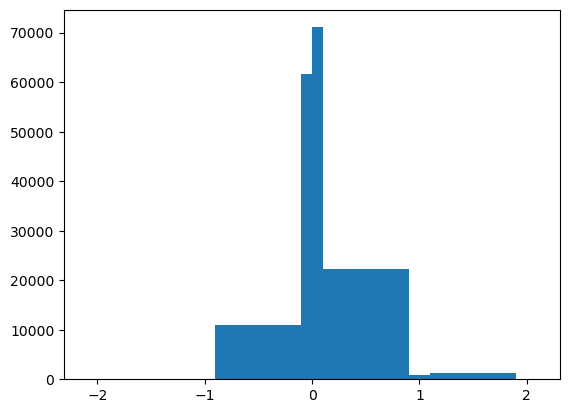

In [256]:
import matplotlib.pyplot as plt
plt.hist(model(torch.tensor(test_inputs).to("cuda").to(torch.float32))[0].cpu().detach().numpy().flatten(), bins = [-2.1, -1.9, -1.1, -0.9, -.1, 0, .1, .9, 1.1, 1.9, 2.1])

In [ ]:
plt.hist(test_inputs.flatten(), bins = [-2.1, -1.9, -1.1, -0.9, -.1, 0, .1, .9, 1.1, 1.9, 2.1])

In [349]:
user_ratings[843:].mean()

0.04012485136741974

In [117]:
results = pd.read_csv("./data/model_results.csv", header= 0, index_col = 0)
results[results.RMSE == results.RMSE.min()]

,Recon Loss,Learning Rate,DetEval,batch size,hidden size,latent size,fixed variance,dropout rate,L2 weight,noise layer std,optimizer,nonlinearity,residual user info,RMSE
200,Likelihood,0.0001,True,32.0,4096.0,2048.0,0.0,0.0,0.0,0.0,Adam,Tanh,True,0.548719


In [119]:
results.sort_values(by="RMSE")

,Recon Loss,Learning Rate,DetEval,batch size,hidden size,latent size,fixed variance,dropout rate,L2 weight,noise layer std,optimizer,nonlinearity,residual user info,RMSE
200,Likelihood,0.00010,True,32.0,4096.0,2048.0,0.0,0.0,0.000,0.0,Adam,Tanh,True,0.548719
0,MSE,0.00010,False,64.0,4096.0,512.0,0.3,0.1,0.001,0.0,Adam,Tanh,True,0.595479
124,Likelihood,0.00001,False,32.0,4096.0,2048.0,0.0,0.0,0.000,0.0,RMSProp,Tanh,False,0.599642
0,MSE,0.00001,False,32.0,4096.0,512.0,0.1,0.0,0.000,0.1,RMSProp,Tanh,True,0.614660
0,MSE,0.00010,False,128.0,4096.0,512.0,0.3,0.1,0.000,0.1,Adam,Tanh,True,0.645789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MSE,0.00005,True,64.0,1024.0,512.0,0.0,0.5,0.000,0.3,Adagrad,Relu,True,1.991779
0,Likelihood,0.00005,True,128.0,2048.0,1024.0,0.5,0.5,0.000,0.1,Adagrad,LeakyRelu,True,2.009543
138,Likelihood,0.00005,False,128.0,2048.0,512.0,0.1,0.5,0.000,0.0,Adagrad,Relu,True,2.023314
67,MSE,0.00005,True,64.0,2048.0,2048.0,0.0,0.3,0.000,0.0,Adagrad,Relu,True,2.036075


In [33]:
epochs = 3000

model = VAE(recon_loss_fcn = "MSE", residual_user_info = True, nonLinearity = "Tanh", dropout_rate = 0.1, fixed_variance = 0.3, deterministicEval = True, noiseLayerStd = 0.0, hidden_size = 4096, latent_size = 512 ).to(device)
optimizer_fcn = "Adam"
learning_rate = 0.0001
l2_weight = 0.001
if optimizer_fcn == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr =  learning_rate, weight_decay = l2_weight)
elif optimizer_fcn == "Adagrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr =  learning_rate)
    l2_weight = 0
elif optimizer_fcn == "RMSProp":
    learning_rate = np.random.choice([5e-6, 1e-5])
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    l2_weight = 0

mse_loss_fcn = nn.MSELoss()

hyperparameters = [recon_loss_fcn, learning_rate, deterministicEval,  batch_size, hidden_size, latent_size, fixed_variance, dropout_rate, l2_weight, noiseLayerStd, optimizer_fcn, nonLinearity, residual_user_info]
print("iteration : " + str(iteration) + " using hyperparameters : " + str(hyperparameters))

all_time_lowest_mse = 0.57954519

for t in range(epochs):
    train(train_dataloader, model,  optimizer, t)
    test(test_dataloader, model, t )
    if t % 100 == 0:
        if model.test_mse < lowest_test_mse_score:
            lowest_test_mse_score = model.test_mse


            if model.test_mse < all_time_lowest_mse:
                torch.save(model.state_dict(), "./models/real_best.pth")
                print("NEW RECORD : " + str(model.test_mse))
                print("New best using hyper parameters : " + str(hyperparameters)  )
                all_time_lowest_mse = model.test_mse

iteration : 11 using hyperparameters : ['MSE', 0.0001, False, 64, 1024, 2048, 0.0, 0.5, 0.001, 0.5, 'Adam', 'LeakyRelu', True]
NEW RECORD : 0.5755844116210938
New best using hyper parameters : ['MSE', 0.0001, False, 64, 1024, 2048, 0.0, 0.5, 0.001, 0.5, 'Adam', 'LeakyRelu', True]
NEW RECORD : 0.5585877895355225
New best using hyper parameters : ['MSE', 0.0001, False, 64, 1024, 2048, 0.0, 0.5, 0.001, 0.5, 'Adam', 'LeakyRelu', True]
NEW RECORD : 0.5474879145622253
New best using hyper parameters : ['MSE', 0.0001, False, 64, 1024, 2048, 0.0, 0.5, 0.001, 0.5, 'Adam', 'LeakyRelu', True]


In [2]:
age = input("Enter your age \n")
sex = input("Enter your sex (M/F) \n")
ratings = {}
while(True):
    respones = input("How do you feel about movie name?\n")
    if (response == "quit"):
        break
    else:
        print(response)

Enter your agequit
Enter your sex (M/F)quit
How do you feel about movie name?
quit


NameError: name 'response' is not defined